# Hyperparameter Importance Analysis for Transformer Model

This notebook analyzes the results from our transformer hyperparameter grid search (IY006B.csv) to determine which hyperparameters have the most significant impact on model performance. We'll use various techniques to assess feature importance:

1. Statistical analysis and visualization
2. Decision tree-based feature importance
3. Permutation importance

Note that this analysis is based on incomplete grid search results, so findings should be considered preliminary.

## Grid Search Configuration

Before diving into the analysis, let's review the hyperparameters that were included in our grid search:

### Basic Hyperparameters
```python
d_models = [128, 256, 512]           # Embedding dimension
nheads = [4, 8, 16]                  # Number of attention heads
num_layers_list = [2, 3]             # Number of transformer layers
dropout_rates = [0.1, 0.01, 0.001]   # Dropout probability
learning_rates = [0.01, 1e-3]        # Learning rate for optimizer
batch_sizes = [64, 128]              # Batch size for training
```

### Extended Hyperparameters
```python
# optimizers = ["Adam", "AdamW"]     # Not included in this experiment
pooling_strategies = ["last", "mean", "learnable"]  # How to pool sequence outputs
use_conv1d_options = [True, False]   # Whether to use 1D convolution
use_auxiliary_options = [False, True]  # Whether to use auxiliary prediction head
gradient_clip_options = [1.0, 5.0]   # Maximum gradient norm
```

### Parameter Grid Generation
```python
param_grid = list(
    itertools.product(
        d_models,
        nheads,
        num_layers_list,
        dropout_rates,
        learning_rates,
        batch_sizes,
        # optimizers,  # Not included in this experiment
        pooling_strategies,
        use_conv1d_options,
        use_auxiliary_options,
        gradient_clip_options,
    )
)
```

This resulted in a total of 5,184 different hyperparameter combinations that were evaluated.

## 1. Load and Prepare Data

First, let's load the CSV file with our grid search results and prepare the data for analysis.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]

# Load the grid search results
results_path = "/home/ianyang/stochastic_simulations/experiments/EXP-25-IY006/data/IY006B.csv"
results_df = pd.read_csv(results_path)

# Display basic information
print(f"Dataset shape: {results_df.shape}")
results_df.head()

Dataset shape: (5184, 14)


,d_model,nhead,num_layers,dropout_rate,learning_rate,batch_size,pooling_strategy,use_conv1d,use_auxiliary,gradient_clip,train_acc,val_acc,test_acc,time
0,128,4,2,0.1,0.01,64,last,True,False,1.0,0.921875,0.943750,0.95625,24.515561
1,128,4,2,0.1,0.01,64,last,True,False,5.0,0.940625,0.978125,0.97750,16.464715
2,128,4,2,0.1,0.01,64,last,True,True,1.0,0.908594,0.959375,0.97000,18.040076
3,128,4,2,0.1,0.01,64,last,True,True,5.0,0.871875,0.915625,0.91625,17.898215
4,128,4,2,0.1,0.01,64,last,False,False,1.0,0.520312,0.534375,0.51500,7.867788


## 2. Data Exploration and Preprocessing

Let's first explore the data to understand the distribution of hyperparameters and their relationship with model performance.

In [9]:
# Check for missing values
print("Missing values in each column:")
print(results_df.isnull().sum())

# Convert boolean columns to proper boolean type
for col in ['use_conv1d', 'use_auxiliary']:
    results_df[col] = results_df[col].astype(bool)

# Basic statistics for numeric columns
print("\nBasic statistics for test accuracy:")
print(results_df['test_acc'].describe())

# Check the unique values for each hyperparameter
print("\nUnique values for each hyperparameter:")
for col in results_df.columns[:10]:  # Only hyperparameter columns
    print(f"{col}: {results_df[col].unique()}")

Missing values in each column:
d_model             0
nhead               0
num_layers          0
dropout_rate        0
learning_rate       0
batch_size          0
pooling_strategy    0
use_conv1d          0
use_auxiliary       0
gradient_clip       0
train_acc           0
val_acc             0
test_acc            0
time                0
dtype: int64

Basic statistics for test accuracy:
count    5184.000000
mean        0.726947
std         0.208925
min         0.427500
25%         0.508750
50%         0.688750
75%         0.983750
max         0.996250
Name: test_acc, dtype: float64

Unique values for each hyperparameter:
d_model: [128 256 512]
nhead: [ 4  8 16]
num_layers: [2 3]
dropout_rate: [0.1   0.01  0.001]
learning_rate: [0.01  0.001]
batch_size: [ 64 128]
pooling_strategy: ['last' 'mean' 'learnable']
use_conv1d: [ True False]
use_auxiliary: [False  True]
gradient_clip: [1. 5.]


## 3. Visualizing Hyperparameter Effects

Let's create visualizations to understand how each hyperparameter affects model performance (test accuracy).

/tmp/ipykernel_453774/1905764532.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_data['value'] = param_data['value'].astype(str)
/tmp/ipykernel_453774/1905764532.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_data['value'] = param_data['value'].astype(str)
/tmp/ipykernel_453774/1905764532.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

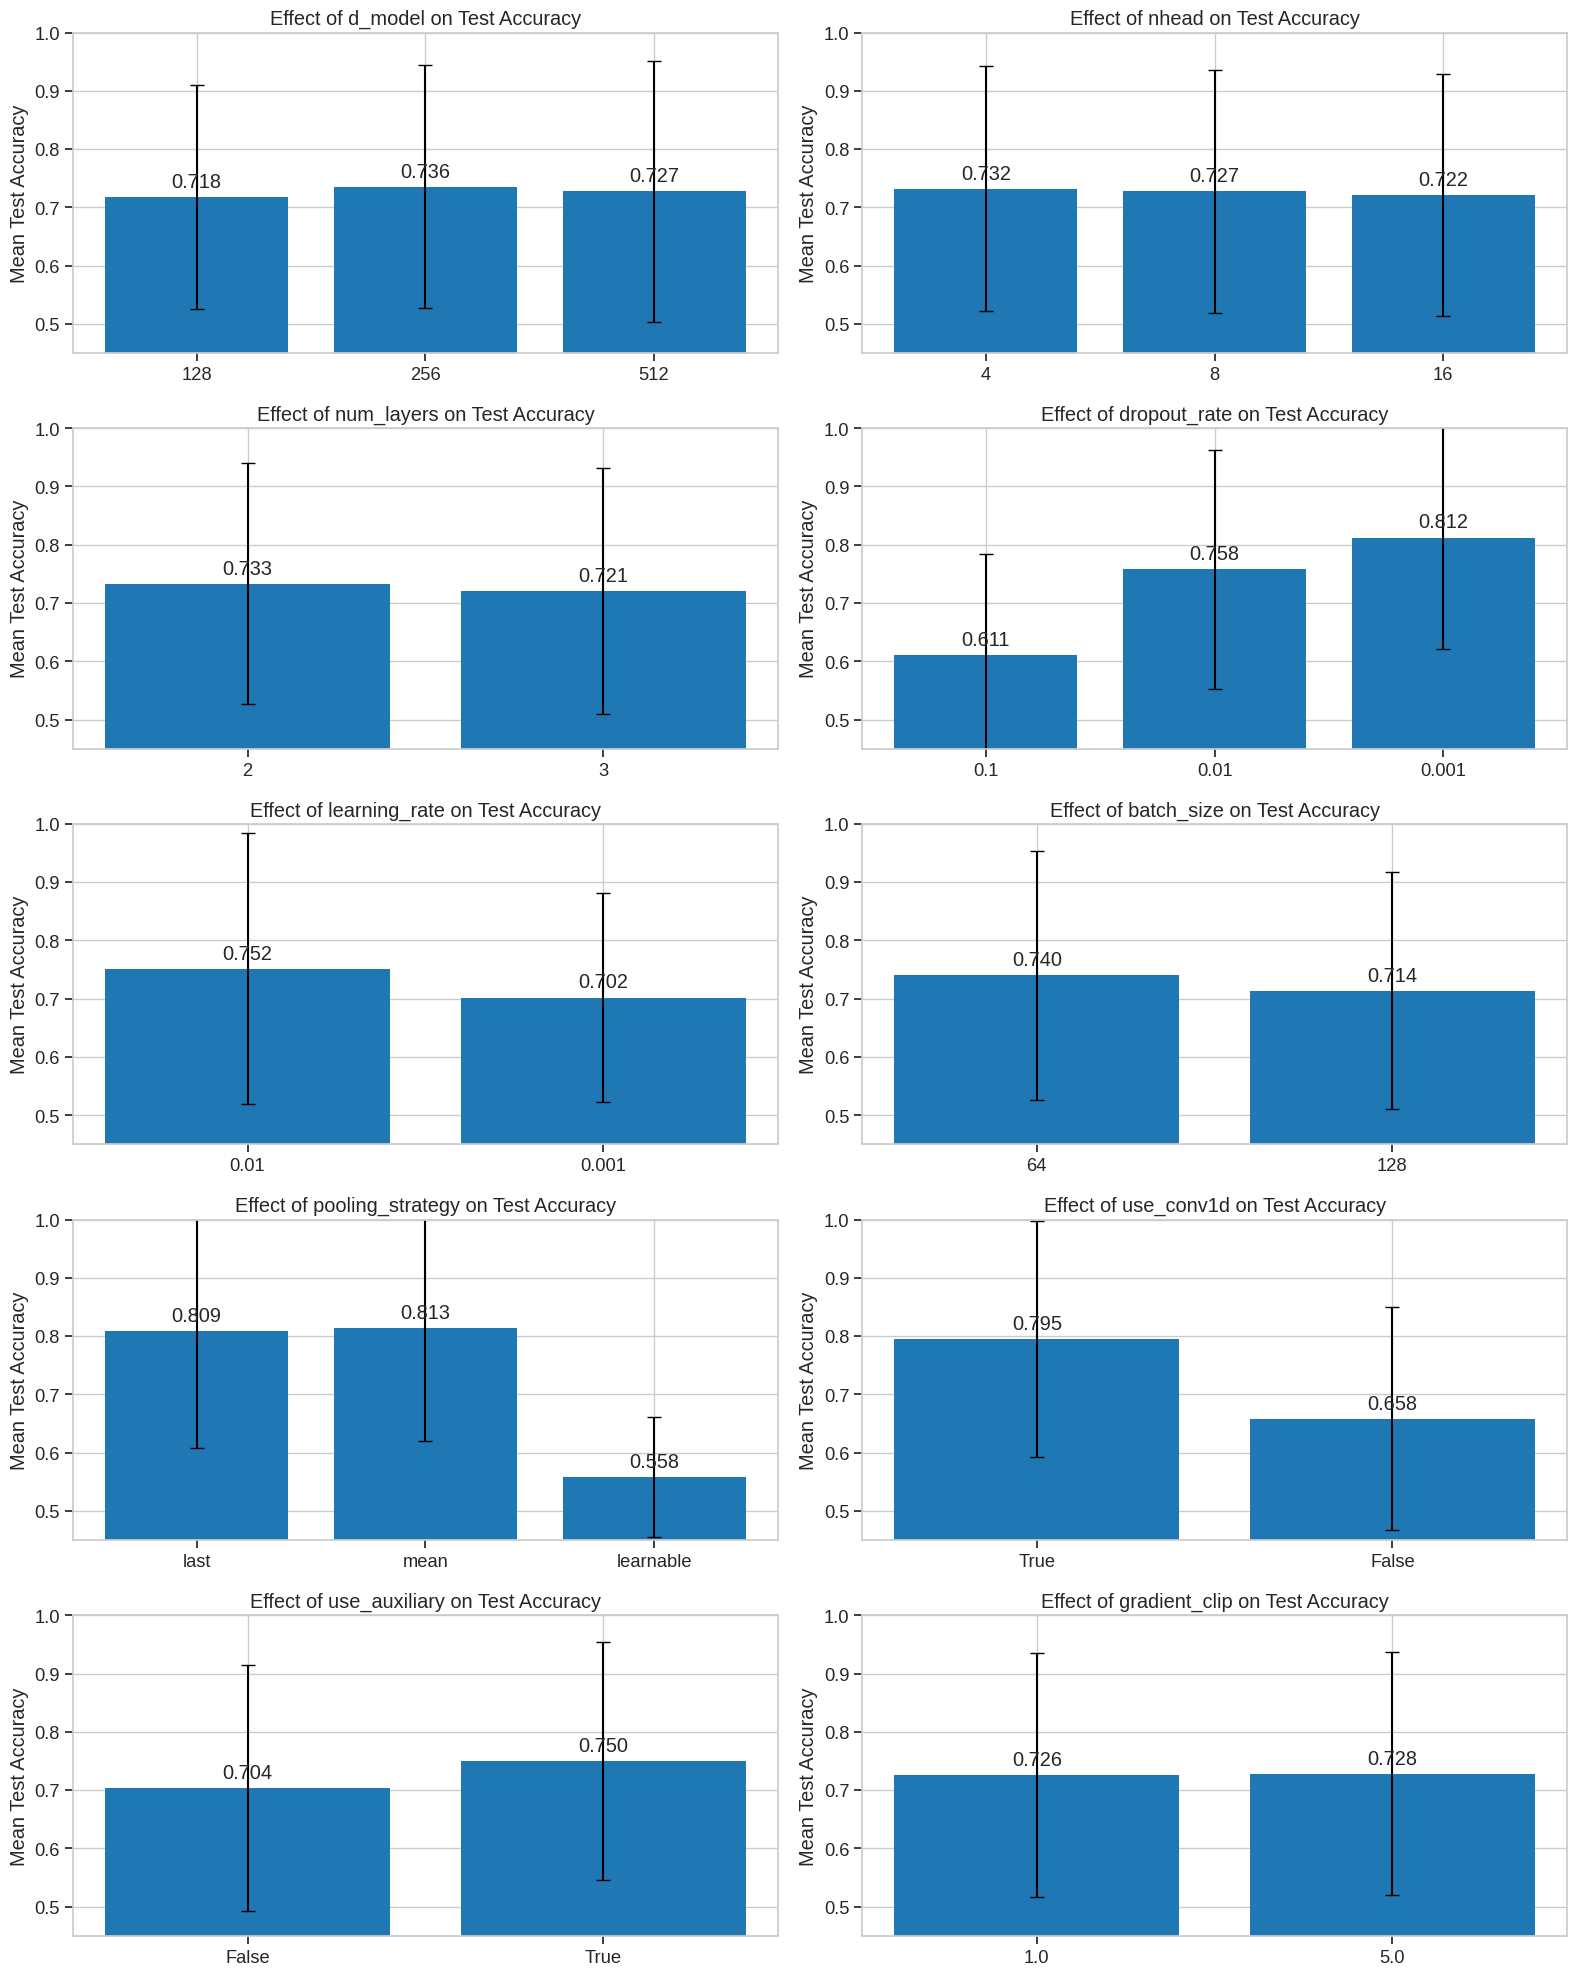

In [10]:
# Create a summary dataframe that aggregates test accuracy for each hyperparameter value
summary_data = []

for col in results_df.columns[:10]:  # Hyperparameter columns
    for value in results_df[col].unique():
        subset = results_df[results_df[col] == value]
        summary_data.append({
            'hyperparameter': col,
            'value': value,
            'mean_test_acc': subset['test_acc'].mean(),
            'std_test_acc': subset['test_acc'].std(),
            'count': len(subset)
        })

summary_df = pd.DataFrame(summary_data)

# Plot the effect of each hyperparameter on test accuracy
plt.figure(figsize=(16, 20))

for i, param in enumerate(summary_df['hyperparameter'].unique()):
    plt.subplot(5, 2, i+1)
    
    # Filter data for this hyperparameter
    param_data = summary_df[summary_df['hyperparameter'] == param]
    
    # Sort by value for better visualization
    if param_data['value'].dtype in [np.float64, np.int64]:
        param_data = param_data.sort_values('value')
    
    # Convert to string for consistent plotting
    param_data['value'] = param_data['value'].astype(str)
    
    # Create bar plot
    bars = plt.bar(param_data['value'], param_data['mean_test_acc'], 
            yerr=param_data['std_test_acc'], capsize=5)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', rotation=0)
    
    plt.title(f'Effect of {param} on Test Accuracy')
    plt.ylabel('Mean Test Accuracy')
    plt.ylim(0.45, 1.0)  # Set y-axis limits for better visualization
    
    # Rotate x-labels if there are many unique values
    if len(param_data) > 4:
        plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 4. Pairwise Interaction Analysis

Let's examine how pairs of hyperparameters interact to affect model performance.

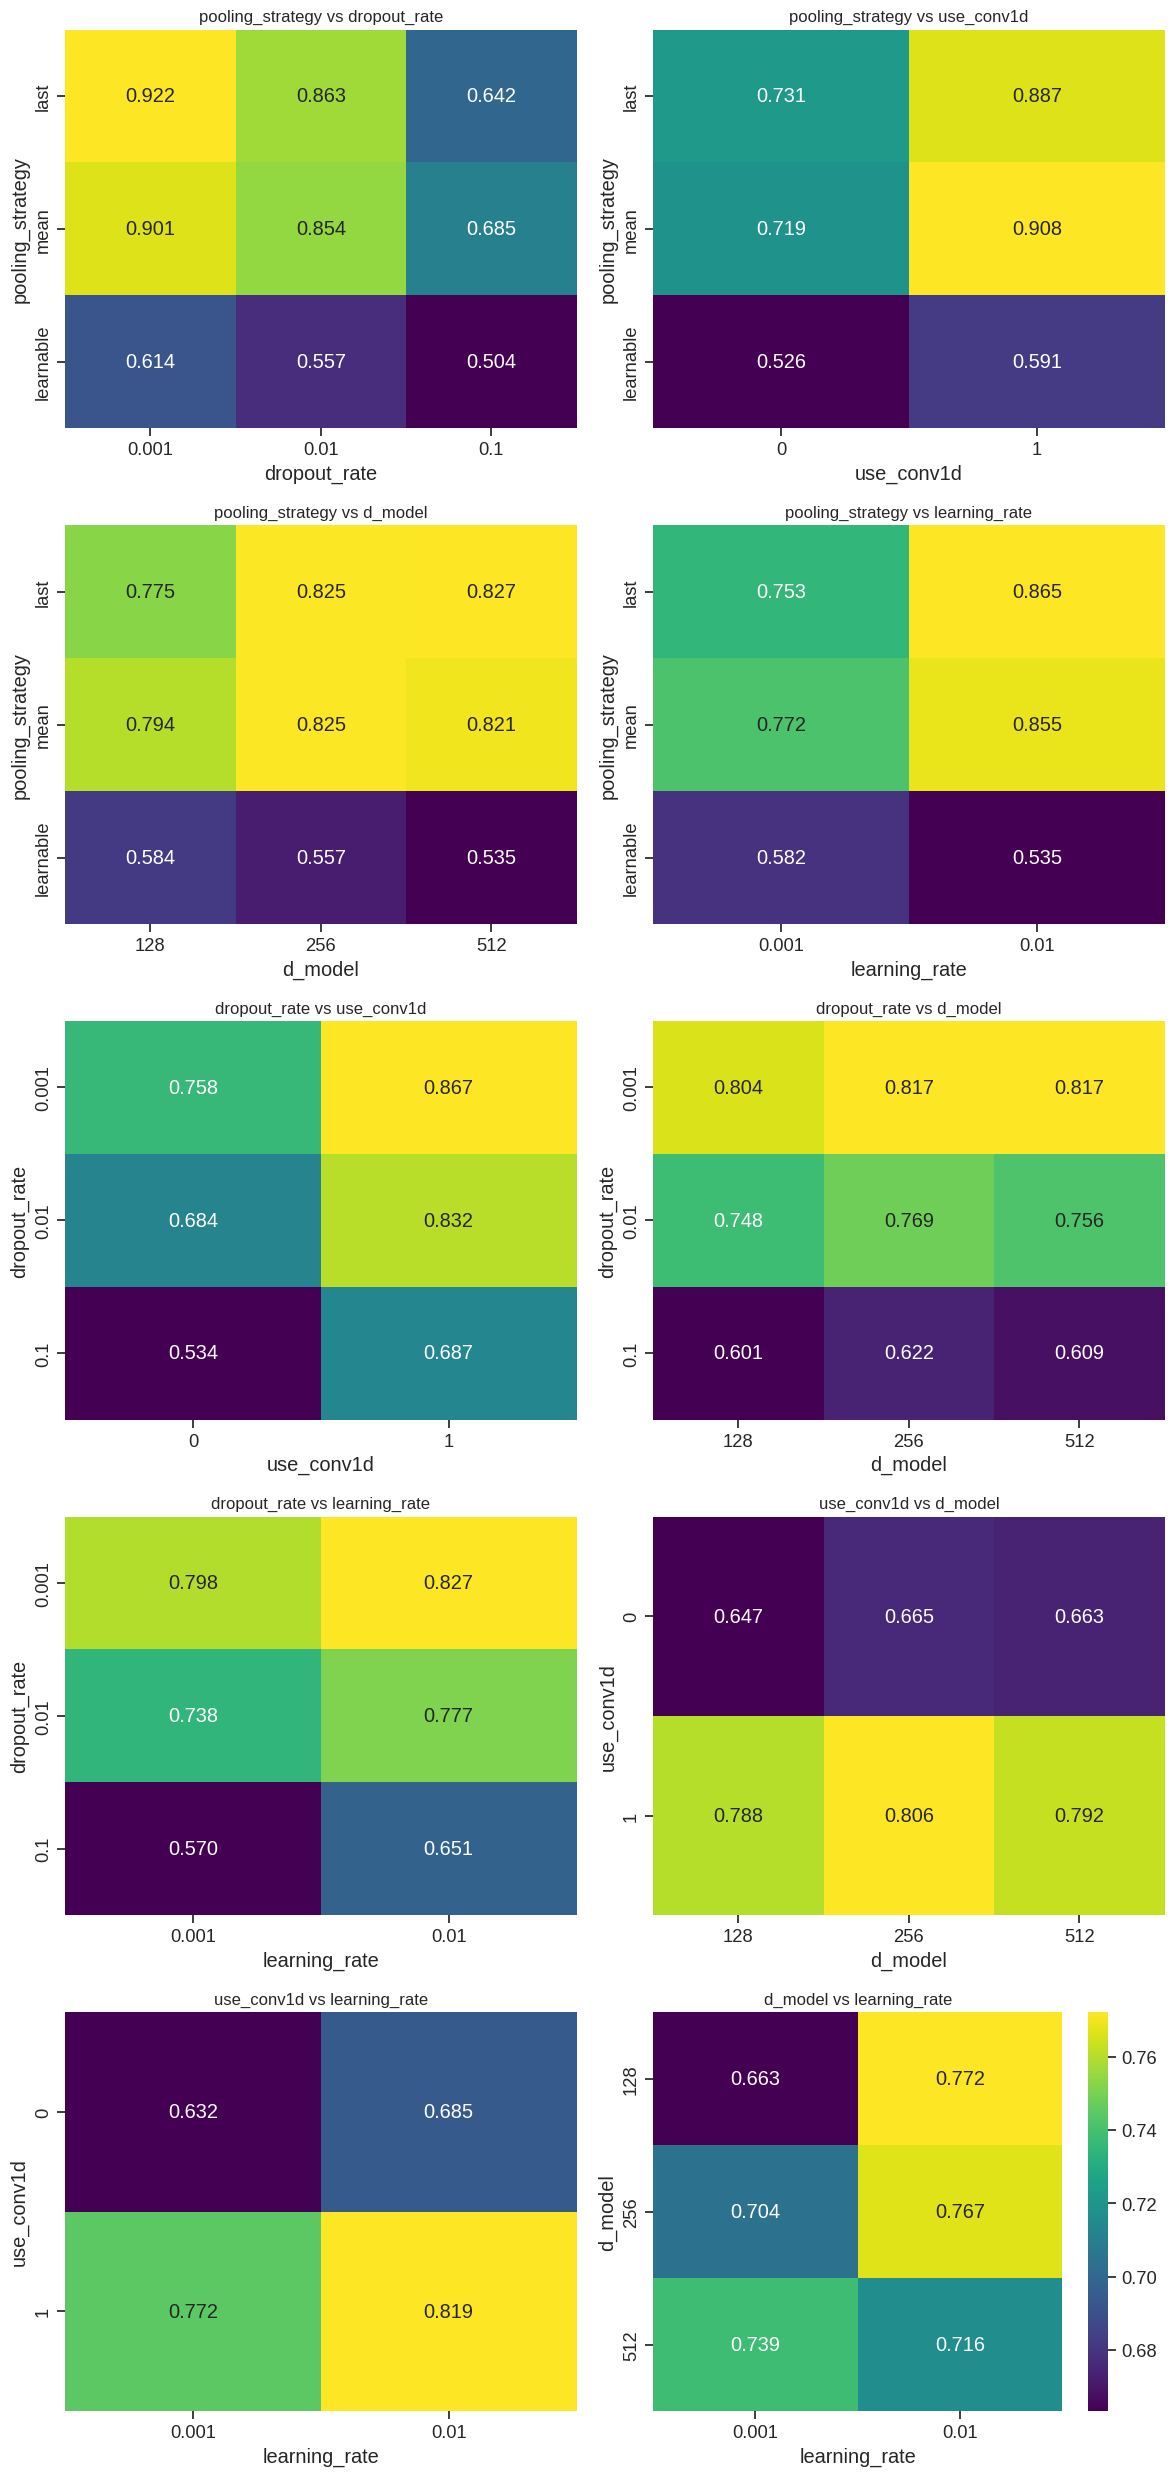

In [57]:
from itertools import combinations

# Mapping for pooling_strategy
pooling_map = {0: 'last', 1: 'mean', 2: 'learnable'}

main_params = ['pooling_strategy', 'dropout_rate', 'use_conv1d', 'd_model', 'learning_rate']
pairwise_combos = list(combinations(main_params, 2))
n_rows, n_cols = 5, 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for idx, (param1, param2) in enumerate(pairwise_combos):
    ax = axes[idx]
    pivot = results_df.pivot_table(
        values='test_acc',
        index=param1,
        columns=param2,
        aggfunc='mean'
    )
    # Remap pooling_strategy axis if present
    if param1 == 'pooling_strategy':
        pivot.index = pivot.index.map(pooling_map)
    if param2 == 'pooling_strategy':
        pivot.columns = [pooling_map.get(x, x) for x in pivot.columns]
    sns.heatmap(pivot, annot=True, cmap='viridis', fmt='.3f', ax=ax, cbar=(idx==len(pairwise_combos)-1))
    ax.set_title(f"{param1} vs {param2}", fontsize=12)
    ax.set_xlabel(param2)
    ax.set_ylabel(param1)

# Hide any unused subplots
for idx in range(len(pairwise_combos), n_rows * n_cols):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


## 5. Decision Tree-Based Feature Importance

We'll use decision trees to calculate feature importance. First, we need to prepare our data by encoding categorical features.

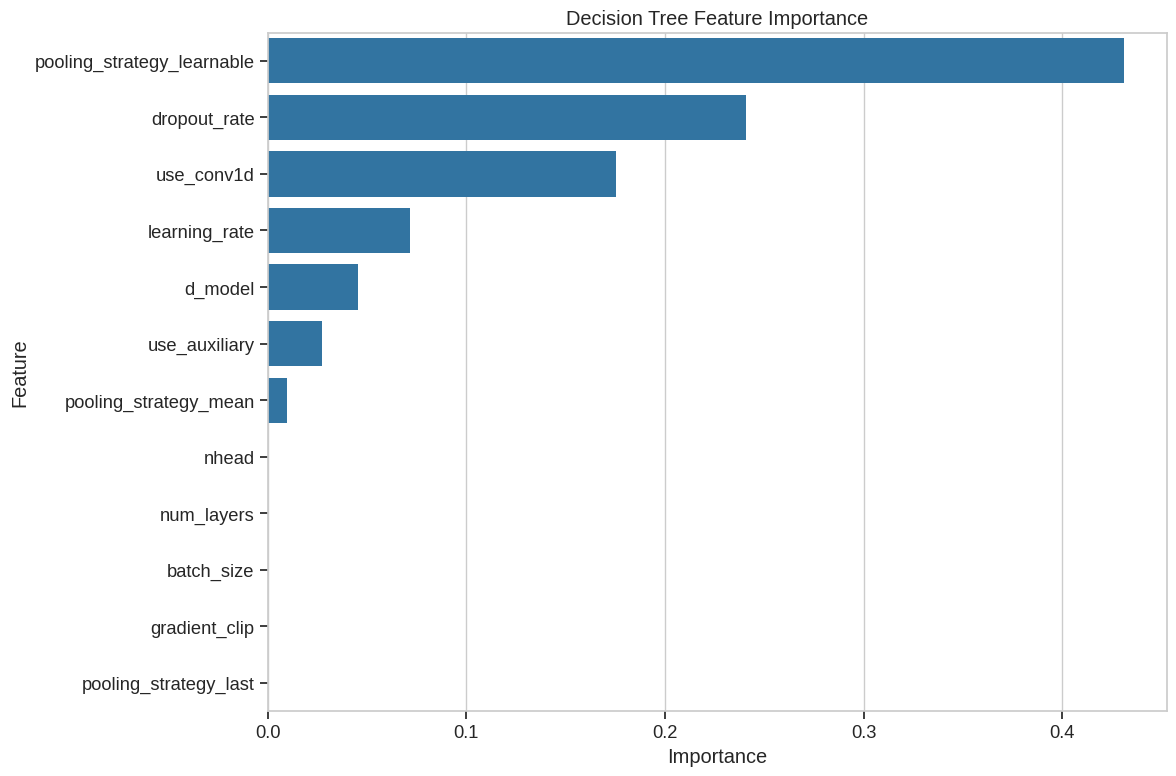

,Feature,Importance
8,pooling_strategy_learnable,0.431094
3,dropout_rate,0.240572
10,use_conv1d,0.175114
4,learning_rate,0.071322
0,d_model,0.045225
11,use_auxiliary,0.027158
9,pooling_strategy_mean,0.009516
1,nhead,0.000000
2,num_layers,0.000000
5,batch_size,0.000000


In [12]:
# Prepare X (features) and y (target)
X = results_df.iloc[:, :10]  # All hyperparameters
y = results_df['test_acc']   # Test accuracy

# Identify categorical columns
categorical_cols = ['pooling_strategy', 'optimizer'] if 'optimizer' in X.columns else ['pooling_strategy']
boolean_cols = ['use_conv1d', 'use_auxiliary']
numeric_cols = [col for col in X.columns if col not in categorical_cols + boolean_cols]

# Create preprocessor with OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('bool', 'passthrough', boolean_cols)
    ], 
    remainder='passthrough'
)

# Create a pipeline with preprocessing and model
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42, max_depth=5))
])

# Fit the model
tree_pipeline.fit(X, y)

# Get feature importance from the decision tree
dt_model = tree_pipeline.named_steps['regressor']
feature_names = (
    numeric_cols + 
    tree_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist() +
    boolean_cols
)

# Get importance scores
importance = dt_model.feature_importances_

# Create DataFrame with feature importance
dt_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})
dt_importance_df = dt_importance_df.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=dt_importance_df)
plt.title('Decision Tree Feature Importance')
plt.tight_layout()
plt.show()

dt_importance_df.head(10)

## 6. Random Forest Feature Importance

Random Forests can provide a more robust measure of feature importance by averaging across multiple decision trees.

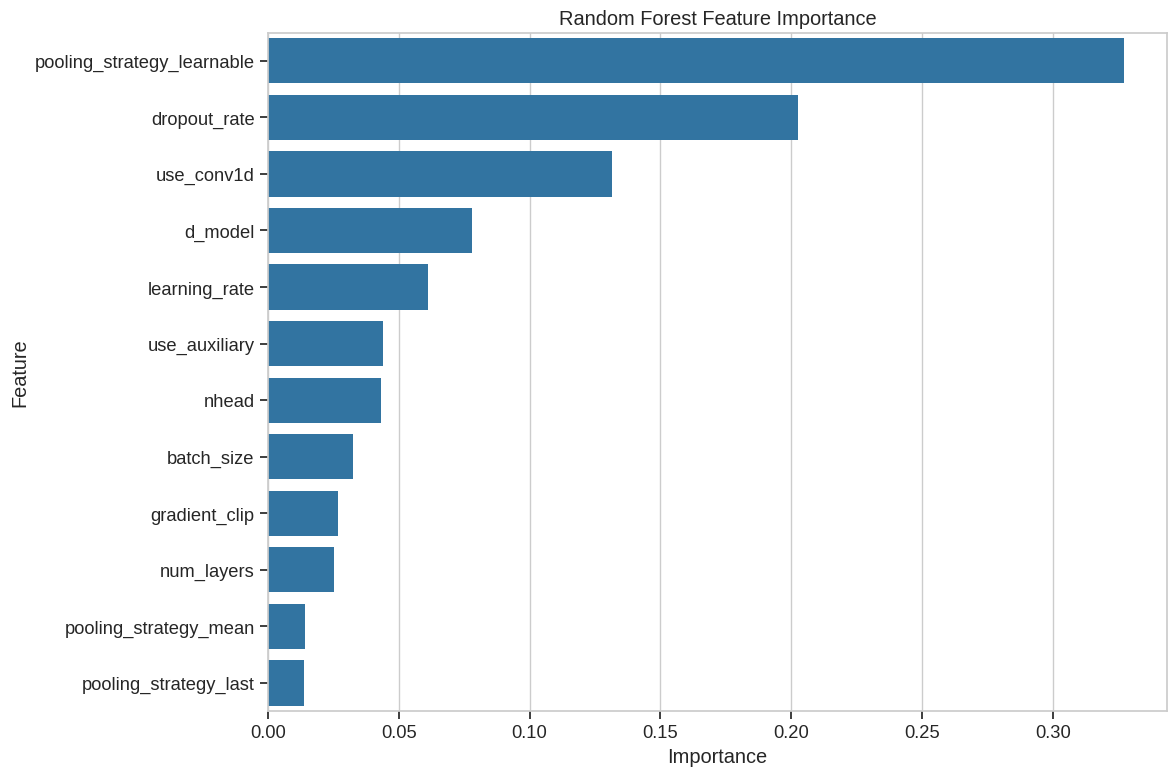

,Feature,Importance
8,pooling_strategy_learnable,0.327196
3,dropout_rate,0.202539
10,use_conv1d,0.131596
0,d_model,0.077886
4,learning_rate,0.061285
11,use_auxiliary,0.043819
1,nhead,0.043192
5,batch_size,0.032660
6,gradient_clip,0.026676
2,num_layers,0.025298


In [13]:
# Create a pipeline with Random Forest regressor
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model
rf_pipeline.fit(X, y)

# Get feature importance from Random Forest
rf_model = rf_pipeline.named_steps['regressor']
rf_importance = rf_model.feature_importances_

# Create DataFrame with feature importance
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importance
})
rf_importance_df = rf_importance_df.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

rf_importance_df.head(10)

## 7. Permutation Importance

Permutation importance measures the decrease in model performance when a feature is randomly shuffled. This can provide insight into which features are most important for predictions.

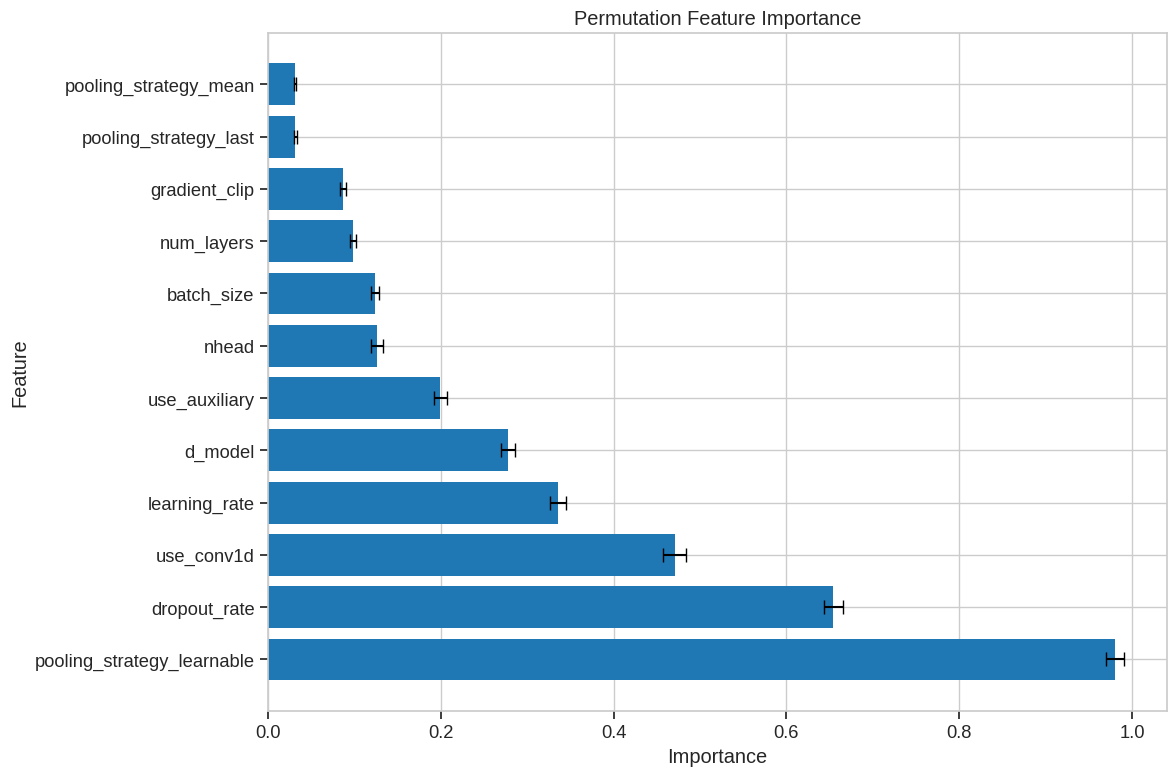

,Feature,Importance,Std
8,pooling_strategy_learnable,0.980153,0.010566
3,dropout_rate,0.654280,0.011249
10,use_conv1d,0.470920,0.013358
4,learning_rate,0.335962,0.009260
0,d_model,0.278209,0.008093
11,use_auxiliary,0.199579,0.007675
1,nhead,0.126374,0.006840
5,batch_size,0.124097,0.004239
2,num_layers,0.098443,0.003783
6,gradient_clip,0.086914,0.003682


In [58]:
# Fit a simple Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# First, apply preprocessing to get transformed feature matrix
X_transformed = preprocessor.fit_transform(X)

# Fit the model on transformed data
rf_model.fit(X_transformed, y)

# Calculate permutation importance
perm_importance = permutation_importance(rf_model, X_transformed, y, 
                                         n_repeats=10, random_state=42)

# Create DataFrame with permutation importance
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})
perm_importance_df = perm_importance_df.sort_values('Importance', ascending=False)

# Plot permutation importance
plt.figure(figsize=(12, 8))
# Use matplotlib directly instead of seaborn for the error bars
plt.barh(y=perm_importance_df['Feature'], 
         width=perm_importance_df['Importance'],
         xerr=perm_importance_df['Std'],
         capsize=5,
         color=sns.color_palette()[0])

plt.title('Permutation Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

perm_importance_df.head(10)

## 8. Hyperparameter Ranking

Let's consolidate the findings from different importance measures and rank the hyperparameters.

In [63]:
# Combine importance scores from different methods
combined_importance = pd.DataFrame({'Feature': feature_names})

combined_importance['DT_Importance'] = dt_importance_df.set_index('Feature').loc[feature_names, 'Importance'].values
combined_importance['RF_Importance'] = rf_importance_df.set_index('Feature').loc[feature_names, 'Importance'].values
combined_importance['Perm_Importance'] = perm_importance_df.set_index('Feature').loc[feature_names, 'Importance'].values

# Calculate average rank across methods
for col in ['DT_Importance', 'RF_Importance', 'Perm_Importance']:
    combined_importance[f'{col}_Rank'] = combined_importance[col].rank(ascending=False)

combined_importance['Avg_Rank'] = combined_importance[[
    'DT_Importance_Rank', 'RF_Importance_Rank', 'Perm_Importance_Rank'
]].mean(axis=1)

# Sort by average rank
combined_importance = combined_importance.sort_values('Avg_Rank')

# Display the rankings
combined_importance[['Feature', 'DT_Importance', 'RF_Importance', 'Perm_Importance', 'Avg_Rank']]


,Feature,DT_Importance,RF_Importance,Perm_Importance,Avg_Rank
8,pooling_strategy_learnable,0.431094,0.327196,0.980153,1.000000
3,dropout_rate,0.240572,0.202539,0.654280,2.000000
10,use_conv1d,0.175114,0.131596,0.470920,3.000000
4,learning_rate,0.071322,0.061285,0.335962,4.333333
0,d_model,0.045225,0.077886,0.278209,4.666667
11,use_auxiliary,0.027158,0.043819,0.199579,6.000000
1,nhead,0.000000,0.043192,0.126374,8.000000
5,batch_size,0.000000,0.032660,0.124097,8.666667
2,num_layers,0.000000,0.025298,0.098443,9.666667
6,gradient_clip,0.000000,0.026676,0.086914,9.666667


## 9. Visualizing the Best Configurations

Let's visualize the top-performing hyperparameter configurations to identify patterns.

Top 10 configurations by test accuracy:


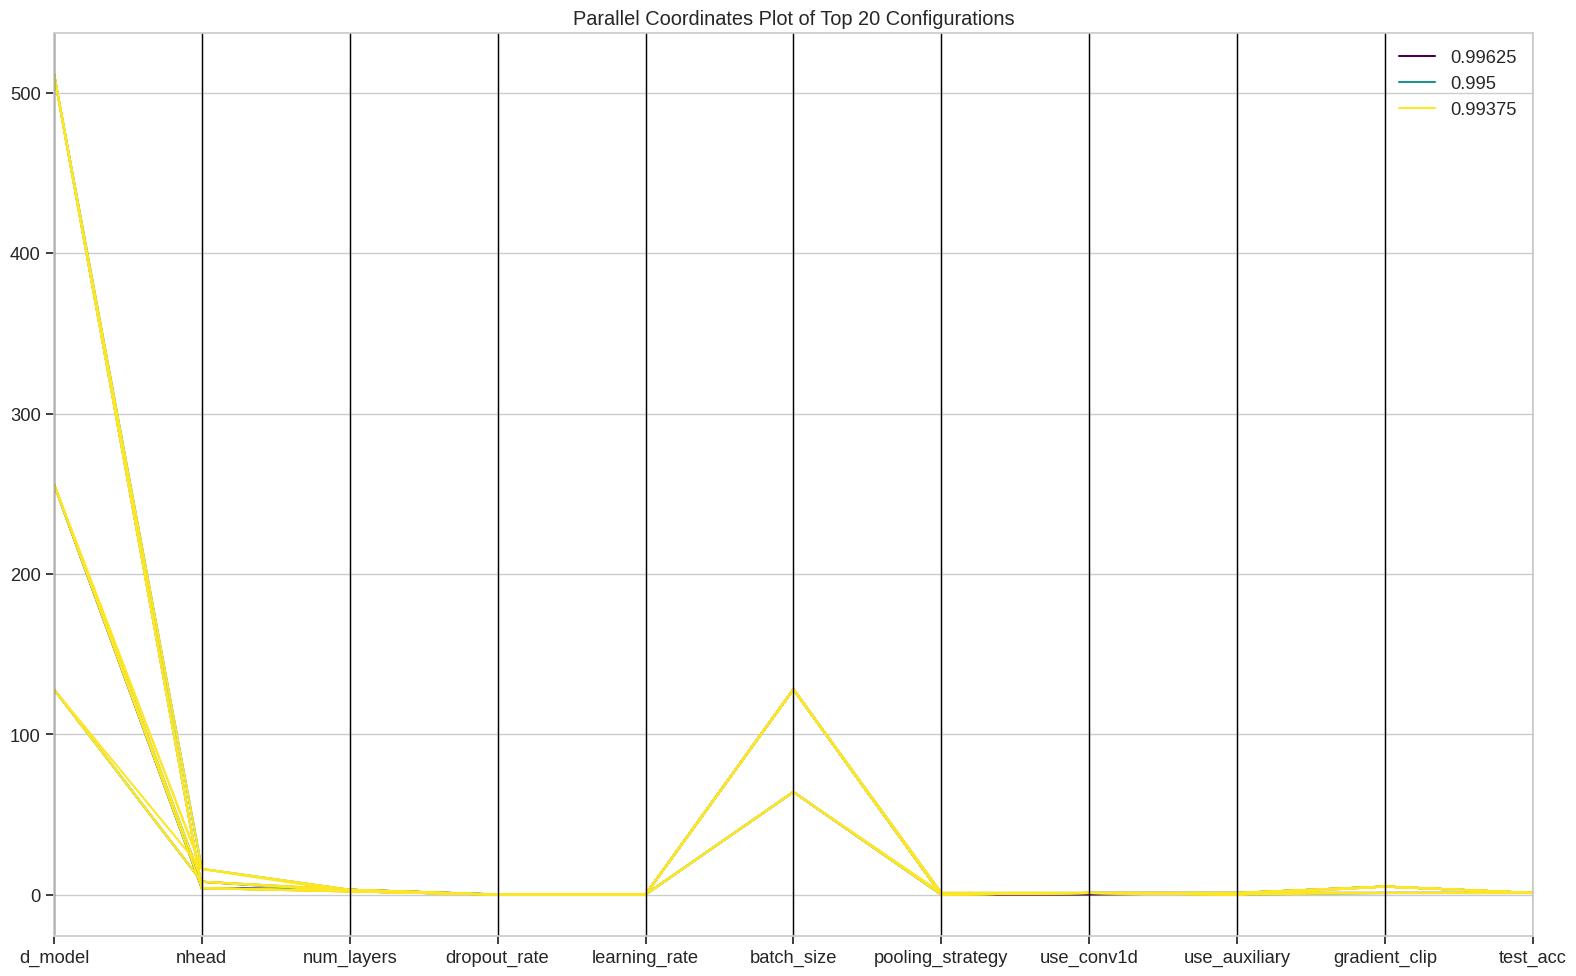

In [60]:
# Sort by test accuracy and select top 10 configurations
top_configs = results_df.sort_values('test_acc', ascending=False).head(10)

# Display top configurations
print("Top 10 configurations by test accuracy:")
top_configs

# Create a parallel coordinates plot for the top configurations
plt.figure(figsize=(16, 10))

# Select columns for parallel coordinates plot
cols_to_plot = [col for col in X.columns] + ['test_acc']

# For boolean and categorical columns, convert to numeric
for col in cols_to_plot:
    if results_df[col].dtype == bool:
        results_df[col] = results_df[col].astype(int)
    elif col == 'pooling_strategy':
        # Map categorical values to integers
        mapping = {val: i for i, val in enumerate(results_df[col].unique())}
        results_df[col] = results_df[col].map(mapping)

# Create parallel coordinates plot with a colormap based on test accuracy
pd.plotting.parallel_coordinates(
    results_df.sort_values('test_acc', ascending=False).head(20),
    'test_acc',
    cols=cols_to_plot,
    colormap='viridis'
)

plt.title('Parallel Coordinates Plot of Top 20 Configurations')
plt.grid(True)
plt.tight_layout()
plt.show()

## 10. Conclusions and Recommendations

Based on our analysis, we can summarize the importance of different hyperparameters and make recommendations for future experiments.

In [19]:
# Create a summary of key findings
print("Key Hyperparameter Importance Findings:")
print("-" * 50)

# Get top 5 important features by average rank
top_features = combined_importance.head(5)['Feature'].tolist()
print(f"Top 5 most important hyperparameters (across all methods):")
for i, feature in enumerate(top_features):
    print(f"{i+1}. {feature}")

print("\nBest hyperparameter configuration found:")
best_config = results_df.loc[results_df['test_acc'].idxmax()]
for param in X.columns:
    print(f"{param}: {best_config[param]}")
print(f"Test Accuracy: {best_config['test_acc']:.4f}")

print("\nRecommendations for future experiments:")
print("1. Focus on fine-tuning the top important hyperparameters identified above")
print("2. Consider narrowing the search space around the best configuration")
print("3. Explore more values for the top hyperparameters to find optimal settings")

Key Hyperparameter Importance Findings:
--------------------------------------------------
Top 5 most important hyperparameters (across all methods):
1. pooling_strategy_learnable
2. dropout_rate
3. use_conv1d
4. learning_rate
5. d_model

Best hyperparameter configuration found:
d_model: 256.0
nhead: 4.0
num_layers: 3.0
dropout_rate: 0.001
learning_rate: 0.01
batch_size: 128.0
pooling_strategy: 0.0
use_conv1d: 1.0
use_auxiliary: 1.0
gradient_clip: 1.0
Test Accuracy: 0.9962

Recommendations for future experiments:
1. Focus on fine-tuning the top important hyperparameters identified above
2. Consider narrowing the search space around the best configuration
3. Explore more values for the top hyperparameters to find optimal settings


## 11. Additional Analysis: Performance vs Training Time

Let's also analyze the trade-off between model performance and training time.

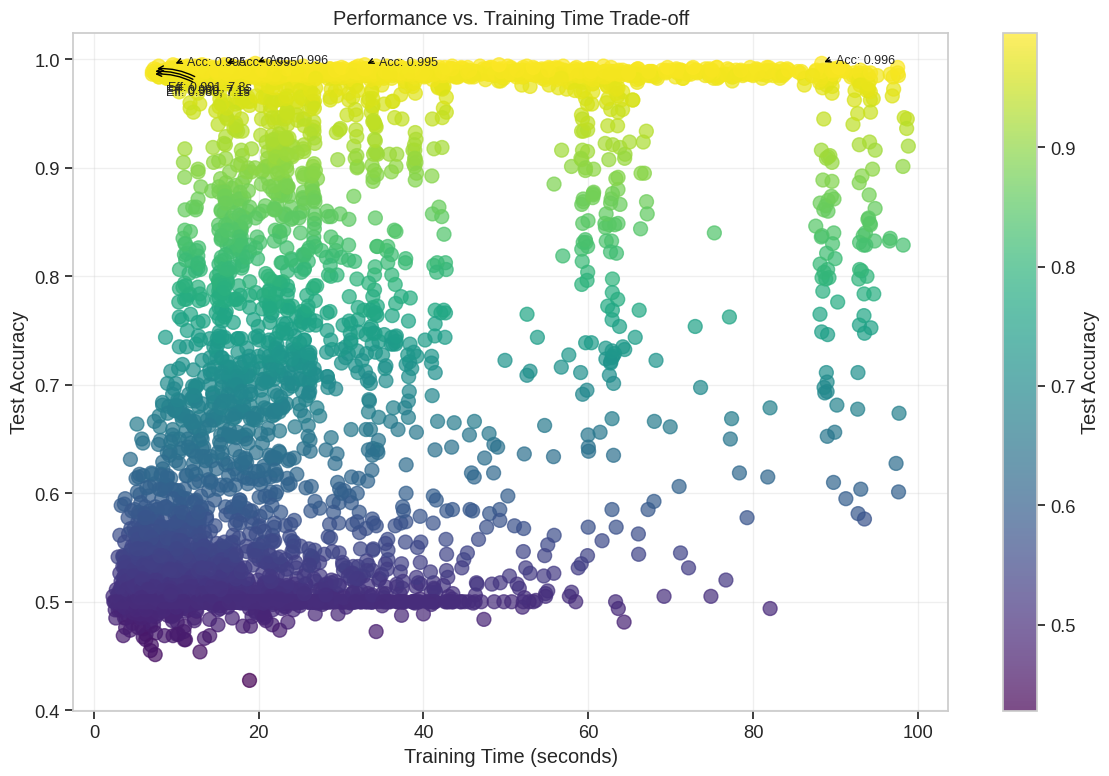

Most efficient configurations (highest accuracy per second):


,test_acc,time,efficiency,d_model,nhead,num_layers,dropout_rate,learning_rate,batch_size,pooling_strategy,use_conv1d,use_auxiliary,gradient_clip
28,0.50500,2.320739,0.217603,128,4,2,0.100,0.010,128,0,0,0,1.0
239,0.50000,2.411856,0.207309,128,4,2,0.001,0.010,128,2,0,1,5.0
140,0.50000,2.527946,0.197789,128,4,2,0.010,0.010,128,2,0,0,1.0
234,0.49250,2.582575,0.190701,128,4,2,0.001,0.010,128,2,1,1,1.0
662,0.51125,2.719245,0.188012,128,8,2,0.100,0.001,128,1,0,1,1.0


In [20]:
# Create a scatter plot of test accuracy vs. training time
plt.figure(figsize=(12, 8))
scatter = plt.scatter(results_df['time'], results_df['test_acc'], 
                     c=results_df['test_acc'], cmap='viridis', 
                     alpha=0.7, s=100)

plt.colorbar(scatter, label='Test Accuracy')
plt.xlabel('Training Time (seconds)')
plt.ylabel('Test Accuracy')
plt.title('Performance vs. Training Time Trade-off')
plt.grid(True, alpha=0.3)

# Annotate points with high accuracy and low training time
for i, row in results_df.nlargest(5, 'test_acc').iterrows():
    plt.annotate(f"Acc: {row['test_acc']:.3f}",
                xy=(row['time'], row['test_acc']),
                xytext=(10, 0),
                textcoords='offset points',
                fontsize=9,
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

# Also annotate points with good accuracy but much faster training
efficient_models = results_df[results_df['test_acc'] > 0.8].nsmallest(3, 'time')
for i, row in efficient_models.iterrows():
    plt.annotate(f"Eff: {row['test_acc']:.3f}, {row['time']:.1f}s",
                xy=(row['time'], row['test_acc']),
                xytext=(10, -15),
                textcoords='offset points',
                fontsize=9,
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

plt.tight_layout()
plt.show()

# Create a dataframe to analyze efficiency (test accuracy per second of training)
results_df['efficiency'] = results_df['test_acc'] / results_df['time']

# Display the most efficient configurations
print("Most efficient configurations (highest accuracy per second):")
results_df.nlargest(5, 'efficiency')[['test_acc', 'time', 'efficiency'] + list(X.columns)]